In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [2]:
url = "https://cran.r-project.org/incoming/UL/diversedata/data-clean/hcmst.csv"
hcmst = pd.read_csv(url)

In [3]:
hcmst.head()

,subject_age,subject_education,subject_sex,subject_ethnicity,subject_income_category,subject_employment_status,same_sex_couple,married,sex_frequency,flirts_with_partner,...,relationship_duration,children,rel_change_during_pandemic,inc_change_during_pandemic,subject_had_covid,partner_had_covid,subject_vaccinated,partner_vaccinated,agree_covid_approach,relationship_quality
0,53.0,high_school_grad,female,white,35k_40k,working_paid_employee,no,not_married,once_or_twice_a_week,a_few_times_a_week,...,1.500000,2.0,better_than_before,no_change,no,yes,not_vaccinated,not_vaccinated,completely_agree,excellent
1,72.0,some_college,female,white,75k_85k,working_paid_employee,no,married,once_a_month_or_less,never,...,57.416668,1.0,no_change,worse,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,mostly_agree,good
2,43.0,associate_degree,male,white,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,a_few_times_a_week,...,22.333334,5.0,no_change,worse,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,completely_agree,excellent
3,64.0,some_college,male,white,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,1_to_3_times_a_month,...,28.250000,2.0,no_change,no_change,no,no,fully_vaccinated_and_booster,fully_vaccinated_and_booster,completely_agree,good
4,60.0,high_school_grad,female,black,75k_85k,working_paid_employee,no,married,once_or_twice_a_week,a_few_times_a_week,...,38.916668,3.0,better_than_before,no_change,no,no,not_vaccinated,partially_vaccinated,completely_agree,excellent


In [18]:
alt.Chart(hcmst).mark_bar(size = 150).encode(
    x=alt.X('relationship_quality', title='Relationship Quality'),
    y='count()'
).properties(
    title='Distribution of Relationship Quality',
    width = 'container'
)

alt.Chart(...)

Text(0.5, 1.0, 'Correlation Matrix of Relevant Predictor Variables')

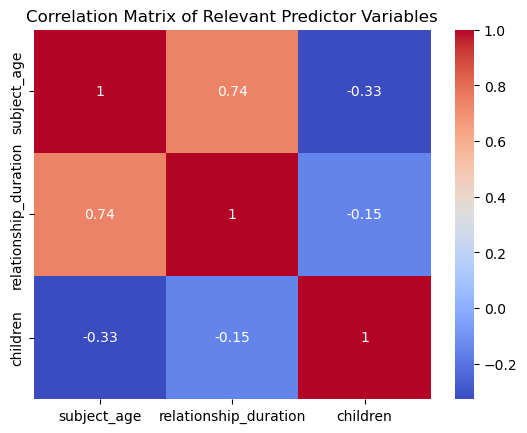

In [5]:
corr_mat = hcmst[['subject_age','relationship_duration', 'children']].corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Relevant Predictor Variables')

In [19]:
alt.Chart(hcmst).mark_bar().encode(
    x=alt.X('subject_income_category', title='Income Category'),
    y='count()'
).properties(
    title='Distribution of Income Category',
    width = 'container'
)

alt.Chart(...)

In [ ]:
income_order = [
    'under_5k',
    '5k_7k',
    '7k_10k',
    '10k_12k',
    '12k_15k',
    '15k_20k',
    '20k_25k',
    '25k_30k',
    '30k_35k',
    '35k_40k',
    '40k_50k',
    '50k_60k',
    '60k_75k',
    '75k_85k',
    '85k_100k',
    '100k_125k',
    '125k_150k',
    '150k_175k',
    '175k_200k',
    '200k_250k',
    'over_250k'
]

alt.Chart(hcmst).mark_bar().encode(
    x=alt.X(
        'subject_income_category',
        sort=income_order,
        title='Income Category'
    ),
    y='count()'
).properties(
    title='Distribution of Income Category',
    width = 'container'
)


alt.Chart(...)